In [2]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import mne
import pandas as pd
import seaborn as sns

from add_subject_utils import (depth, frontal, get_all_channels_info,
                               get_scalp_channels_info,
                               rename_bonn_depth_channels)

In [3]:
mne.set_log_level("error")

Step 1: Data Inspection

In [ ]:
excel_path = "https://docs.google.com/spreadsheets/d/1vZ5Aml_UeHb_UByep1Qlj-GXY9sui_dDwrh1tMynJOw/export?format=csv&gid="
excel_channels_per_sub, excel_channels_count = get_scalp_channels_info(excel_path)
dir_name = "clean_zeeg"
real_channels_per_sub, real_channels_count = get_all_channels_info(Path(fr"D:\Shaked_data\{dir_name}"))

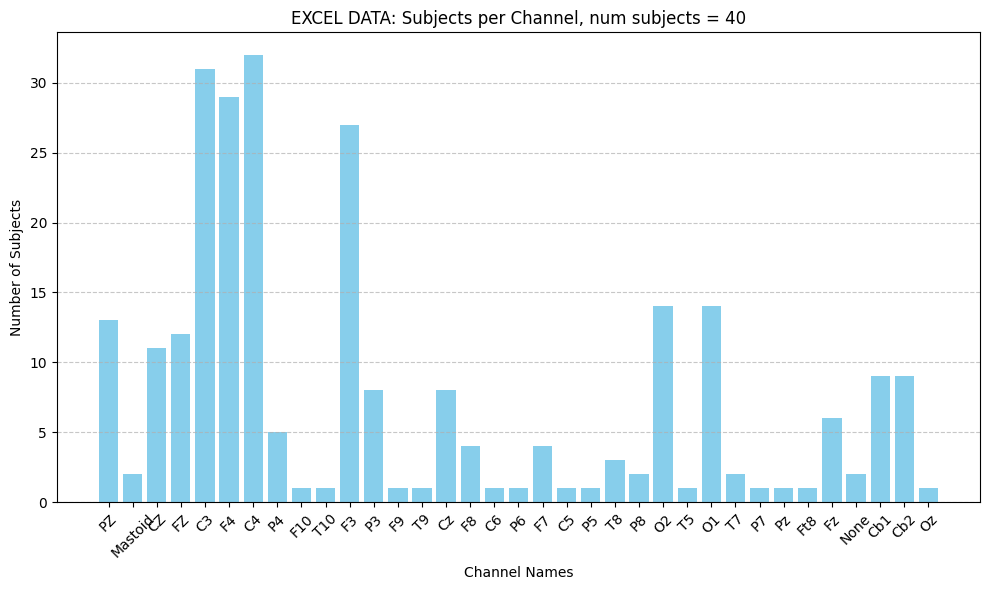

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(list(excel_channels_count.keys()), list(excel_channels_count.values()), color='skyblue')
plt.xlabel('Channel Names')
plt.ylabel('Number of Subjects')
plt.title(f'EXCEL DATA: Subjects per Channel, num subjects = {len(excel_channels_per_sub)}')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

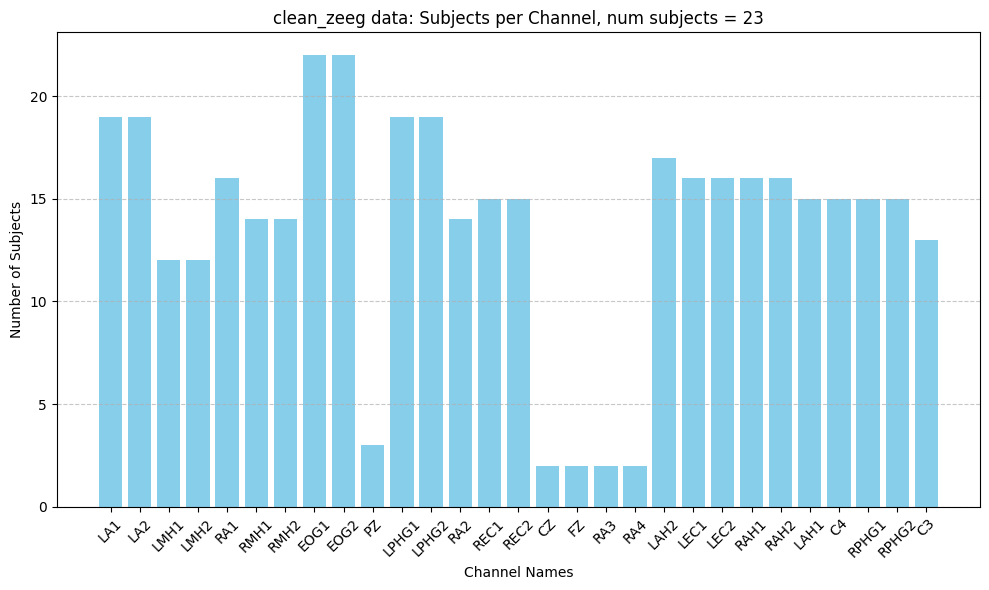

In [ ]:
# real_scalp_count = {k: v for k, v in real_channels_count.items() if k in frontal}
plt.figure(figsize=(10, 6))
plt.bar(list(real_channels_count.keys()), list(real_channels_count.values()), color='skyblue')
plt.xlabel('Channel Names')
plt.ylabel('Number of Subjects')
plt.title(f'{dir_name} data: Subjects per Channel, num subjects = {len(real_channels_per_sub)}')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

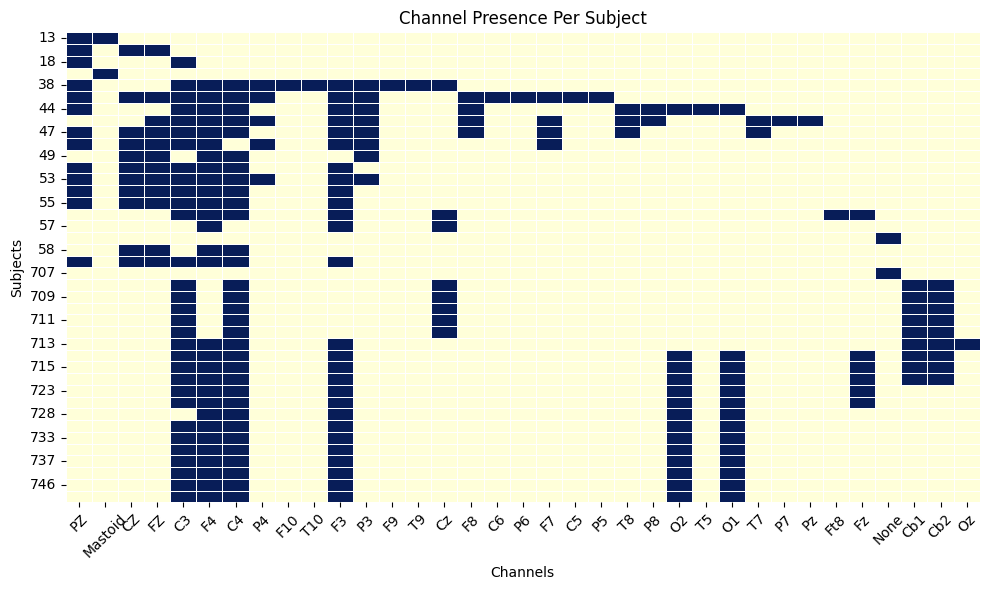

In [ ]:
data = {sub: [1 if channel in channels else 0 for channel in excel_channels_count.keys()]
        for sub, channels in excel_channels_per_sub.items()}

df = pd.DataFrame.from_dict(data, orient='index', columns=excel_channels_count.keys())

plt.figure(figsize=(10, 6))
sns.heatmap(df, cbar=False, cmap="YlGnBu", linewidths=0.5)
plt.title("Channel Presence Per Subject")
plt.xlabel("Channels")
plt.ylabel("Subjects")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [4]:
F3_excel = [k for k in excel_channels_per_sub if 'F3' in excel_channels_per_sub[k]]
F4_excel = [k for k in excel_channels_per_sub if 'F4' in excel_channels_per_sub[k]]
F3_real = [k for k in real_channels_per_sub if 'F3' in real_channels_per_sub[k]]
F4_real = [k for k in real_channels_per_sub if 'F4' in real_channels_per_sub[k]]
F3_miss = sorted([x for x in F3_excel if x not in F3_real])
F4_miss = sorted([x for x in F4_excel if x not in F4_real])
print(f"missing in F3: {F3_miss} ({len(F3_miss)})")
print(f"missing in F4: {F4_miss} ({len(F4_miss)})")

missing in F3: ['38', '39', '44', '46', '47', '48', '51', '53', '54', '55', '56', '57', '59', '713', '714', '715', '723', '724', '728', '731', '733', '734', '735', '737', '744', '746', '752'] (27)
missing in F4: ['38', '39', '44', '46', '47', '48', '49', '51', '53', '54', '55', '56', '57', '58', '59', '713', '714', '715', '723', '724', '728', '731', '733', '734', '735', '737', '744', '746', '752'] (29)


In [ ]:
sheet_gids = {"TLV": 0, "Bonn": 753590609}
sheets = {name: pd.read_csv(f"{excel_path}{gid}", index_col=0) for name, gid in sheet_gids.items()}
directory = r"D:\Shaked_data\base_full_data"
error_by_subject = {}

Step 2: Filtering

In [11]:
files = sorted(os.listdir(directory))
for sub in F3_miss:
    try:
        step = "loading"
        file = [f for f in files if f.startswith(f"P{sub}")][0]
        full_path = os.path.join(directory, file)
        raw = mne.io.read_raw(full_path)
        city = "Bonn" if int(sub) > 699 else "TLV"

        step = "filtering"
        if city == "Bonn" and 'overnightData' not in full_path:
            # the files that were not processed at all (didn't change the names)
            rename_bonn_depth_channels(raw)
        curr_frontal = [x for x in frontal if x in raw.ch_names]
        curr_depth = [x for x in depth if x in raw.ch_names]
        raw.pick(curr_depth + curr_frontal)
        raw.load_data()
        h_freq = 500 if raw.info['sfreq'] > 1000 else raw.info['sfreq'] // 2 - 1
        raw.filter(l_freq=0.1, h_freq=h_freq, picks=curr_depth, phase='zero-double')
        
        # TODO: check what's the relevant notch
        raw.notch_filter((50, 100, 150, 200), method='spectrum_fit', phase='zero-double')
        raw.filter(l_freq=0.1, h_freq=40, picks=curr_frontal, phase='zero-double')
        raw.resample(1000)
        
        step = "cropping"
        tmin = str(sheets[city][sub].loc["crop (tmin)"])
        tmin = int(tmin) if tmin.isdigit() else 0
        tmax = str(sheets[city][sub].loc["crop (tmax)"])
        tmax = int(tmax) if tmax.isdigit() else None
        raw.crop(tmin=tmin, tmax=tmax)
        
        step = "saving"
        raw.save(rf'D:\Shaked_data\filtered_with_scalp\P{sub}_scalp_filtered.fif', overwrite=True)
    
    except Exception as e:
        error_by_subject[sub] = (step, e)

Step 3: Manual Cleaning

In [41]:
sub = "731"
city = "Bonn"
x_channels_excel = [ch for ch, val in sheets[city][sub].items() if str(val).upper() == "X"]
raw = mne.io.read_raw_fif(rf"D:\Shaked_data\filtered_with_scalp\P{sub}_scalp_filtered.fif")
possibly_bads = [x for x in x_channels_excel if x in raw.ch_names]

print(f"look at {possibly_bads}")

look at []
should reference


In [18]:
# set previously marked annotations if they exist
clean = mne.io.read_raw(fr"D:\Shaked_data\clean_zeeg\P{sub}_mtl_clean.fif")
raw.set_annotations(clean.annotations)

In [21]:
raw.set_channel_types({x: 'seeg' for x in depth if x in raw.ch_names})
# raw.set_channel_types({x: 'eog' for x in ['EOG1', 'EOG2']})
raw.plot(duration=30, n_channels=len(raw.ch_names), scalings=dict(eeg=5e-5, eog=4e-4, seeg=1e-4))

<mne_qt_browser._pg_figure.MNEQtBrowser(0x201e8b85890) at 0x000001EDC90FFF40>

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\mne_qt_browser\_pg_figure.py:3061: RuntimeWarning: Failed to disconnect (None) from signal "triggered()".
  sig.disconnect()


In [22]:
print(raw.info['bads'])
raw.info['description'] = f"Bad channels: {', '.join(raw.info['bads'])}"
raw.drop_channels(raw.info['bads'], on_missing='ignore')
raw.save(fr'D:\Shaked_data\clean_with_scalp\P{sub}_scalp_clean.fif', overwrite=True)

[]
